# Preparation (libraries, config, data)

Download repo (only necessary if this is a gist on colab or just a solo notebook).

In [ ]:
!rm -rf ./sample_data
!git config --global init.defaultBranch main
!git init .
!git remote add origin https://github.com/Brukmoon/gpt-czech-poetry
!git fetch
!git checkout main

Vocab (not necessary if the git LFS works)

In [ ]:
#!gdown https://drive.google.com/uc?id=1XIw4dO-5Wfg3bHpbAC4oyGzafMUM3q5B -O data/poetry/meta.pkl
#!gdown https://drive.google.com/uc?id=1T5ueEBg8c0e32jOeoMStThHthTjBps1k -O data/poetry/train.bin
#!gdown https://drive.google.com/uc?id=1qPtlQdepEBoA9Dbmxv756X3fmSErL2vT -O data/poetry/val.bin

Base model (not necessary if the git LFS works)

In [21]:
#!mkdir out-base
#!gdown https://drive.google.com/uc?id=1ZOwvqVkEMXLWV56fggsO3zj26M1WFi6n -O out-base/ckpt.pt

The code uses numpy, pytorch and ipywidgets other than standard Python libraries. Run requirements.sh first.

In [1]:
import os
import time
import math
import pickle
from contextlib import nullcontext
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import inspect
from dataclasses import dataclass
#!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import clear_output
import matplotlib.pyplot as plt
from visu import *
from utils import *
import scipy.spatial as sp

### Configuration

In [2]:
# eval
eval_interval = 250 # keep frequent because we'll overfit
log_interval = 5 ## how often to show loss during training
eval_iters = 50 ## how many times to randomly sample a batch during eval
eval_only = False # if True, script exits right after the first eval
always_save_checkpoint = False # if True, always save a checkpoint after each eval

# data
dataset = 'poetry' ## from which folder to load the dataset files
batch_size = 128 # this is the micro-batch size

# model configuration
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'

@dataclass
class GPTConfig:
    name: str = ''
    block_size: int = 128
    vocab_size: int = 50304
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 384
    dropout: float = 0.1
    bias: bool = False # do we use bias inside LayerNorm and Linear layers?

# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
# bfloat has 8 instead of 5 bits for exponent, weights of NNs tend to be small
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = False # use PyTorch 2.0 to compile the model to be faster (i.e. 2x speedup, compiles code to JIT kernels)
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging
# if not ddp, we are running on a single gpu, and one process
torch.manual_seed(1337)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

### Load data

In [3]:
data_dir = os.path.join('data', dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
print(f"loaded data, sample (first ten tokens) = {train_data[:10]}")
# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path}), sample = {list(meta['itos'].items())[40:60]}")
model_args = {'vocab_size':meta_vocab_size}
gptconf = GPTConfig(**model_args)
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - gptconf.block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+gptconf.block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+gptconf.block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

loaded data, sample (first ten tokens) = [ 44  71  82  72 140 101  60 101   1  78]
found vocab_size = 164 (inside data/poetry/meta.pkl), sample = [(40, 'N'), (41, 'O'), (42, 'P'), (43, 'Q'), (44, 'R'), (45, 'S'), (46, 'T'), (47, 'U'), (48, 'V'), (49, 'W'), (50, 'X'), (51, 'Y'), (52, 'Z'), (53, '['), (54, ']'), (55, '_'), (56, '`'), (57, 'a'), (58, 'b'), (59, 'c')]


In [4]:
# look for the meta pickle in case it is available in the dataset folder
meta_path = os.path.join('data', dataset, 'meta.pkl')
load_meta = os.path.exists(meta_path)

print(f"Loading meta from {meta_path}...")
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
# TODO want to make this more general to arbitrary encoder/decoder schemes
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

Loading meta from data/poetry/meta.pkl...


# Model

For the following exercise, an already trained model is needed.

In [5]:
model, checkpoint = load_model('out-base', gptconf, ptdtype, device, device_type)

number of parameters: 10.68M


Full definition of a GPT Language Model, all of it in this single cell.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py

## Encoding

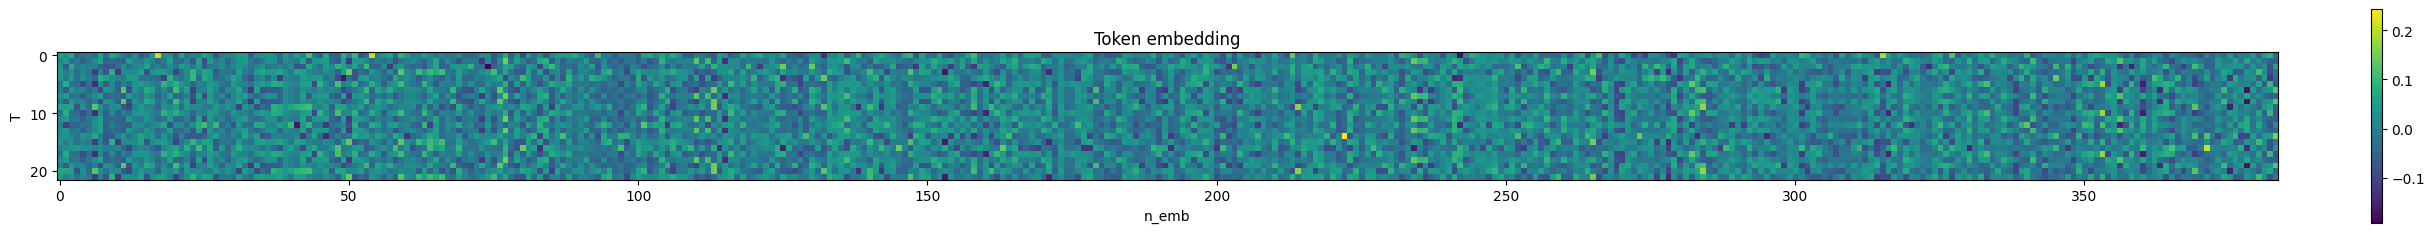

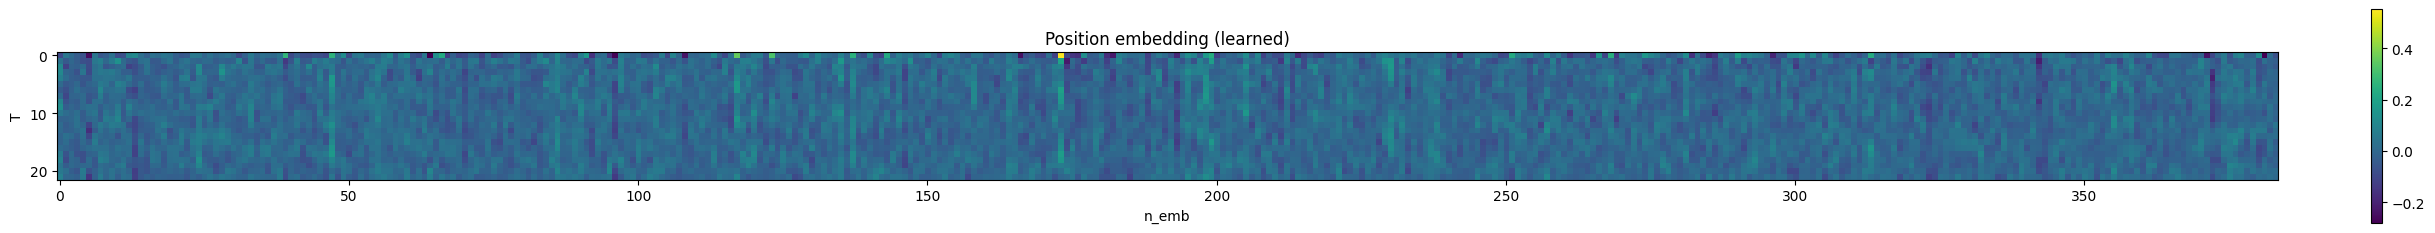

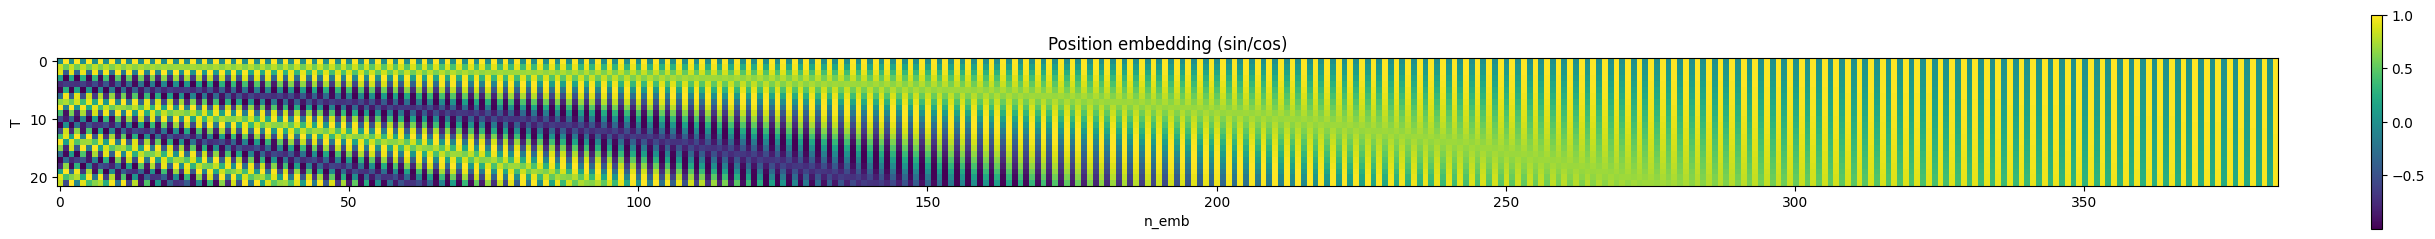

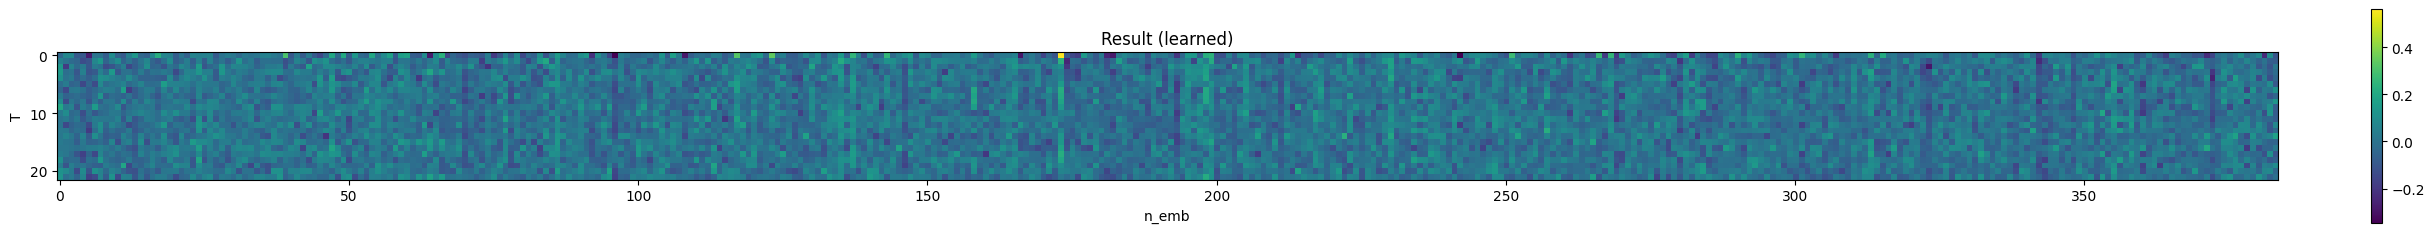

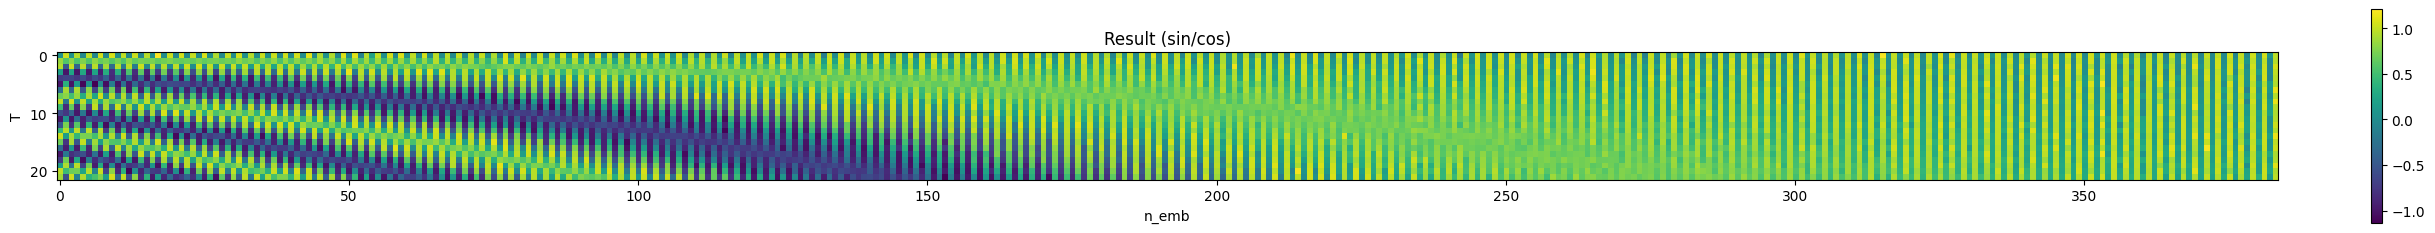

In [6]:
start = "a kolem mne i pode mno"                                           ## 22
start_ids = encode(start)                                                  ## 22
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])  ## 22
pos = torch.arange(0, len(start_ids), dtype=torch.long, device=device)     ## 22
pe = model.transformer.wpe(pos)                                            ## 22x384
te = model.transformer.wte(x)                                              ## 22x384
y = pe + te                                                                ## result from encoding, 22x384

# Fixed position embedding.
def getPositionEmbedding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

visu_all(te, pe, getPositionEmbedding, y, n=100)

Maybe finetune the model on the sin/cos embedding?

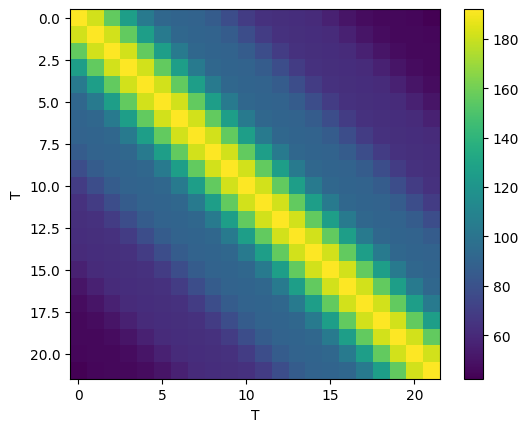

In [7]:
P = getPositionEmbedding(pe.shape[0], pe.shape[1], n=100)
A = P@P.T
plt.imshow(A)
plt.xlabel("T")
plt.ylabel("T")
plt.colorbar()

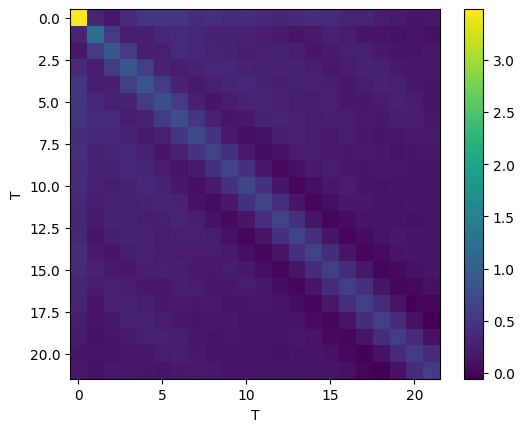

In [8]:
pnp = pe.cpu().detach().numpy().copy()
plt.imshow(pnp@pnp.T)
plt.xlabel("T")
plt.ylabel("T")
plt.colorbar()

## Transformer forward pass

In [9]:
def infer(model, x, temperature, top_k):
    for block in model.transformer.h:
        x_n, _ = block.attn(block.ln_1(x))
        x = x + x_n                   # Skip connection, 1x22x384
        x = x + block.mlp(block.ln_2(x))           # Skip connection #2, 1x22x384
    x = model.transformer.ln_f(x)      # Final layer norm, 1x22x384
    logits = model.lm_head(x[:, [-1], :])  # Final linear layer, tied to WTE, 164x384
    # TRAINING
    # loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
    logits = logits[:, -1, :]/temperature
    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
    logits[logits < v[:, [-1]]] = -float('Inf')
    probs = F.softmax(logits, dim=-1)
    visualise_probs(probs, stoi)
    idx_next = torch.multinomial(probs, num_samples=1)
    print(decode(start_ids))
    print(decode(start_ids + idx_next.cpu().numpy().tolist()[0]))

visu_inference(infer, model, y)

FloatSlider(value=0.8, description='Temperature:', min=0.01)

IntSlider(value=10, description='Top K:', min=1)

Output()

## Layer-by-layer

$$
Layer Norm(X) = \frac{x - E[x]}{\sqrt{Var(x) + \epsilon}} * \gamma + \beta
$$

In [10]:
## LayerNorm here == InstanceNorm. Normalization does not introduce any new dependencies between training cases, is done per-token
##  LayerNorm as activation function https://www.alignmentforum.org/posts/jfG6vdJZCwTQmG7kb/re-examining-layernorm
## see https://arxiv.org/pdf/1607.06450.pdf
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        ## Usually has size n_embd.
        self.weight = nn.Parameter(torch.ones(ndim))

    def forward(self, input):
        ## torch.nn.functional.layer_norm(input, normalized_shape, weight=None, bias=None, eps=1e-05)
        return F.layer_norm(input, self.weight.shape, self.weight, None, 1e-5)

In [11]:
weights = torch.Tensor([1,1,1,1,1,1])
w = nn.Parameter(weights)
## Token a which has vector representation [0, 0, 2, 2], its a-ness learnt from data.
## Thhe layer norm may decide that certain parts of the hidden state should be normalized "less"
token = torch.Tensor([2, 2, 2, 5, 5, 5])
print(f"Token representation: {token}")
print(f"Mean {np.mean(token.numpy())}, var {np.var(token.numpy())}")
print(f"New token representation {F.layer_norm(token, w.shape, w, None, 1e-5).detach().numpy()}")

Token representation: tensor([2., 2., 2., 5., 5., 5.])
Mean 3.5, var 2.25
New token representation [-0.9999978 -0.9999978 -0.9999978  0.9999978  0.9999978  0.9999978]


Weights learned in our sample model.

In [13]:
model.transformer.h[0].ln_1.weight

Parameter containing:
tensor([0.7310, 0.6909, 0.6652, 0.7530, 0.7268, 0.7451, 0.6090, 0.6893, 0.6754,
        0.6735, 0.6633, 0.6534, 0.6409, 0.7244, 0.6943, 0.6830, 0.7818, 0.6129,
        0.6947, 0.7014, 0.6432, 0.6761, 0.7280, 0.6237, 0.6689, 0.6415, 0.7147,
        0.6635, 0.7640, 0.7162, 0.7433, 0.6714, 0.7436, 0.6937, 0.6779, 0.7068,
        0.7125, 0.6696, 0.6539, 0.6661, 0.7272, 0.6333, 0.6655, 0.6362, 0.6744,
        0.6383, 0.6771, 0.6604, 0.6205, 0.6467, 0.6517, 0.6183, 0.5970, 0.6902,
        0.5864, 0.7344, 0.7291, 0.6791, 0.6815, 0.6004, 0.7270, 0.7109, 0.6669,
        0.6934, 0.6720, 0.6516, 0.6716, 0.7440, 0.7097, 0.6446, 0.6804, 0.6408,
        0.6560, 0.6385, 0.6870, 0.6400, 0.6983, 0.6731, 0.6730, 0.6708, 0.5826,
        0.6456, 0.7052, 0.6473, 0.5842, 0.6575, 0.7014, 0.6749, 0.6897, 0.6884,
        0.7836, 0.6660, 0.6694, 0.6196, 0.6955, 0.6491, 0.7030, 0.6878, 0.6757,
        0.6805, 0.6842, 0.6953, 0.6621, 0.6958, 0.7063, 0.5773, 0.6179, 0.7073,
        0.6727, 0.

$$
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
$$

In [14]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        # Why?? --> We must be able to divide the encoding between the heads.
        # This is done to reduce true computational complexity (atn is quadratic) and increase model capacity
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # causal mask to ensure that attention is only applied to the left in the input sequence
        # THERE WAS A QUESTION ABOUT MASKING
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # NOTE: Here it's important to understand we create a new embedding where each element is a
        # linear combination of the weights and old embedding
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        # Each head looks only on PART of the embedding.
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # efficient attention using Flash Attention CUDA kernels
        #    y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        # manual implementation of attention
        # data flowing FNN (one - all) vs CNN (one to neighbors)  vs TNN (one to whoever says the data)
        # show that causal attention can theoretically code for number of tokens it can attend to
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y, att

Step by step attention.
- Get Q,K,V weights from data.
- Compute normalized logits as matrix multiplication of Q and K divided by sqrt of K dimension.
- Do causal masking.
- Softmax.

In [15]:
yn = model.transformer.h[0].ln_1(y)

In [16]:
def get_kqv(layer, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # NOTE: Here it's important to understand we create a new embedding where each element is a
        # linear combination of the weights and old embedding
        q, k, v  = layer.c_attn(x).split(layer.n_embd, dim=2)
        # Each head looks only on PART of the embedding.
        k = k.view(B, T, layer.n_head, C // layer.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, layer.n_head, C // layer.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, layer.n_head, C // layer.n_head).transpose(1, 2) # (B, nh, T, hs)
        return k,q,v

K,Q,V = get_kqv(model.transformer.h[0].attn, yn)
att = (Q @ K.transpose(-2, -1)) * (1.0 / math.sqrt(K.size(-1)))

In [17]:
K.shape

torch.Size([1, 6, 22, 64])

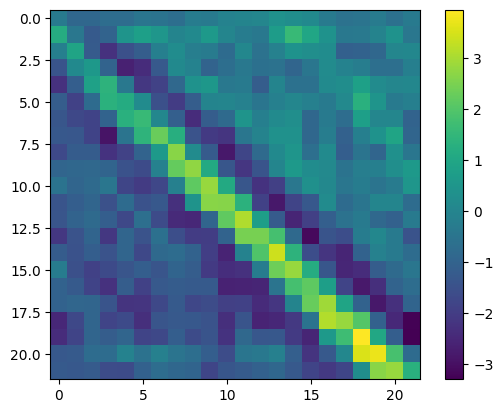

In [18]:
plt.imshow(att.cpu().detach()[0,0,:,:])
plt.colorbar()

In [19]:
att = att.masked_fill(model.transformer.h[0].attn.bias[:,:,:y.size(1),:y.size(1)] == 0, float('-inf'))

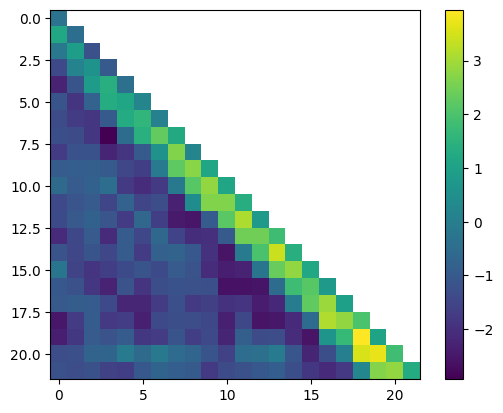

In [20]:
plt.imshow(att.cpu().detach()[0,0,:,:])
plt.colorbar()

In [21]:
att = F.softmax(att, dim=-1)

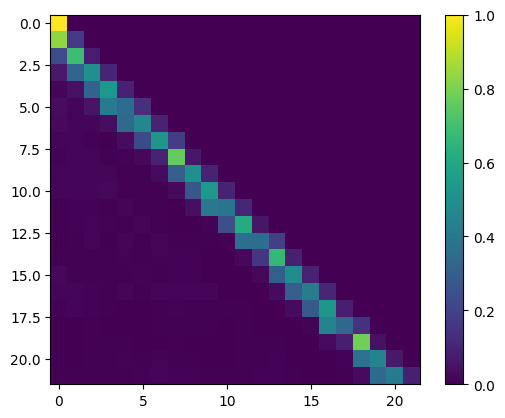

In [22]:
plt.imshow(att.cpu().detach()[0,0,:,:])
plt.colorbar()

Cosine similarity of Q to itself.

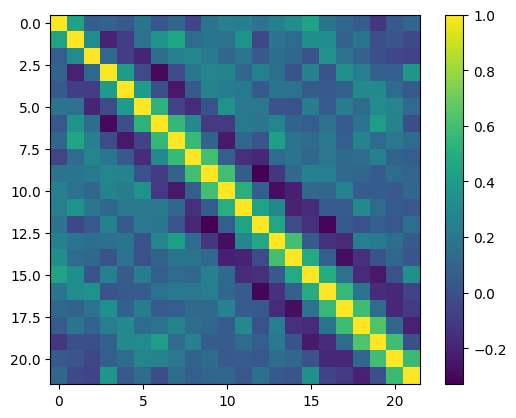

In [23]:
plt.imshow(1 - sp.distance.cdist(Q.cpu().detach()[0,0,:,:], Q.cpu().detach()[0,0,:,:], 'cosine'))
plt.colorbar()

In [24]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        # 4 * n_embd is the MLP size from the AIAYN paper.
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

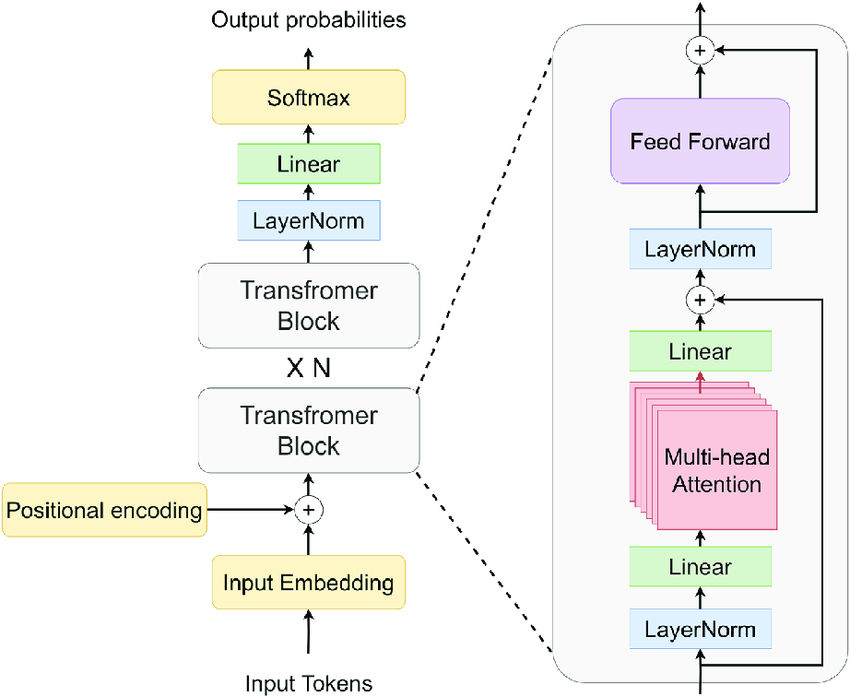

In [25]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)
        self.attM = None

    def forward(self, x):
        x_n, self.attM = self.attn(self.ln_1(x))
        x = x + x_n
        x = x + self.mlp(self.ln_2(x))
        return x

In [27]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        attList = []
        for block in self.transformer.h:
            if block.attM is not None:
                attList.append(block.attM.cpu()) # B, H, T, T
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss, attList

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


## Train

Why is val loss lower? Maybe dropout?

In [28]:
def train(conf, out_dir, max_iters, compare_runs = []):
    os.makedirs(out_dir, exist_ok=True)
    model = GPT(conf)
    model.to(device)
    init_from = 'scratch'
    lr_decay_iters = max_iters
    # adamw optimizer
    learning_rate = 1e-3 # with baby networks can afford to go a bit higher
    weight_decay = 1e-1
    beta1 = 0.9
    beta2 = 0.99 # make a bit bigger because number of tokens per iter is small
    grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
    
    # learning rate decay settings
    decay_lr = True # whether to decay the learning rate
    warmup_iters = 75 # not super necessary potentially
    min_lr = 1e-4 # learning_rate / 10 usually
    gradient_accumulation_steps = 1 # used to simulate larger batch sizes

    # init these up here, can override if init_from='resume' (i.e. from a checkpoint)
    iter_num = 0
    best_val_loss = 1e9

    # initialize a GradScaler. If enabled=False scaler is a no-op
    scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

    # optimizer
    optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)

    # compile the model
    if compile:
        print("compiling the model... (takes a ~minute)")
        unoptimized_model = model
        model = torch.compile(model) # requires PyTorch 2.0

    att = [[],[]]
    # helps estimate an arbitrarily accurate loss over either split using many batches
    @torch.no_grad()
    def estimate_loss():
        out = {}
        ## we go into eval mode, sets all relevant layers to eval mode
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            attL = None
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss, attL = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        # Save only 1 iter
        att[0].append(attL)
        att[1].append(Y)
        model.train()
        return out

    # learning rate decay scheduler (cosine with warmup)
    def get_lr(it):
        # 1) linear warmup for warmup_iters steps
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)

    # training loop
    X, Y = get_batch('train') # fetch the very first batch
    t0 = time.time()
    local_iter_num = 0 # number of iterations in the lifetime of this process
    train_loss_list, val_loss_list = [], [] # store loss

    while True:

        # determine and set the learning rate for this iteration
        lr = get_lr(iter_num) if decay_lr else learning_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # evaluate the loss on train/val sets and write checkpoints
        if iter_num % eval_interval == 0:
            losses = estimate_loss()
            val_loss_list.append(losses['val'])
            #print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

            if losses['val'] < best_val_loss or always_save_checkpoint:
                best_val_loss = losses['val']
                if iter_num > 0:
                    checkpoint = {
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'model_args': model_args,
                        'iter_num': iter_num,
                        'best_val_loss': best_val_loss,
                        'config': config,
                    }
                    print(f"saving checkpoint to {out_dir}")
                    torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))
        if iter_num == 0 and eval_only:
            break

        # forward backward update, with optional gradient accumulation to simulate larger batch size
        # and using the GradScaler if data type is float16
        for micro_step in range(gradient_accumulation_steps):
            with ctx:
                logits, loss, _ = model(X, Y)
                loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
            # immediately async prefetch next batch while model is doing the forward pass on the GPU
            X, Y = get_batch('train')
            # backward pass, with gradient scaling if training in fp16
            scaler.scale(loss).backward()
        # clip the gradient
        if grad_clip != 0.0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        # step the optimizer and scaler if training in fp16
        scaler.step(optimizer)
        scaler.update()
        # flush the gradients as soon as we can, no need for this memory anymore
        optimizer.zero_grad(set_to_none=True)

        # timing and logging
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        if iter_num % log_interval == 0:
            # get loss as float. note: this is a CPU-GPU sync point
            # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
            lossf = loss.item() * gradient_accumulation_steps
            train_loss_list.append(lossf)
            #print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
            clear_output(wait=True)
            plt.plot([a*log_interval for a in range(len(train_loss_list))], train_loss_list, label='Train loss')
            for run in compare_runs:
                plt.plot([a*log_interval for a in range(len(train_loss_list))], run[0][:len(train_loss_list)], label='Train;' + run[2])
                plt.plot(list(range(0,iter_num+1,eval_interval)), run[1][:len(val_loss_list)], label='Val;' + run[2])
            plt.plot(list(range(0,iter_num+1,eval_interval)),val_loss_list, label='Val loss')
            plt.xlabel("iter")
            plt.ylabel("loss")
            plt.legend()
            plt.show()
        iter_num += 1
        local_iter_num += 1

        # termination conditions
        if iter_num > max_iters:
            return (train_loss_list,val_loss_list,conf.name, att)

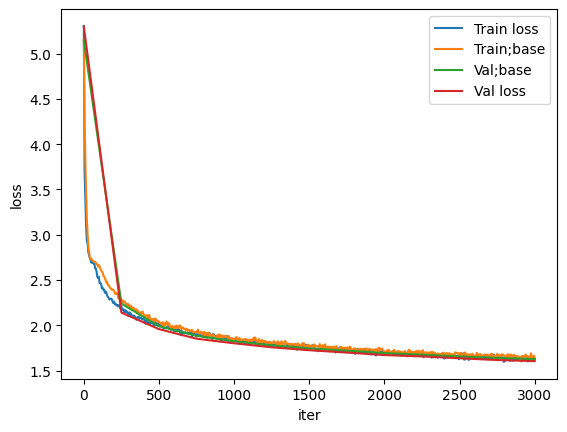

In [11]:
model_confs = [ GPTConfig(name = 'base', block_size = 128,vocab_size = meta_vocab_size,n_layer = 6,n_head = 6,n_embd = 384,dropout = 0.1,bias = False),
              GPTConfig(name = 'emb', block_size = 128,vocab_size = meta_vocab_size,n_layer = 6,n_head = 6,n_embd = 768,dropout = 0.1,bias = False),
              #GPTConfig(name = 'block', block_size = 256,vocab_size = meta_vocab_size,n_layer = 6,n_head = 6,n_embd = 384,dropout = 0.1,bias = False),
              #GPTConfig(name = 'sing', block_size = 128,vocab_size = meta_vocab_size,n_layer = 1,n_head = 1,n_embd = 384,dropout = 0.1,bias = False),
              #GPTConfig(name = 'layer8', block_size = 128,vocab_size = meta_vocab_size,n_layer = 8,n_head = 6,n_embd = 384,dropout = 0.1,bias = False),
              #GPTConfig(name = 'head', block_size = 128,vocab_size = meta_vocab_size,n_layer = 6,n_head = 8,n_embd = 384,dropout = 0.1,bias = False),
              #GPTConfig(name = 'layer3', block_size = 128,vocab_size = meta_vocab_size,n_layer = 3,n_head = 6,n_embd = 384,dropout = 0.1,bias = False)
            ]
runs = []
for rc in model_confs:
    runs.append(train(rc,'out-'+rc.name,3000, runs))

In [12]:
with open("runs.pkl", "wb") as f:
    pickle.dump(runs, f)

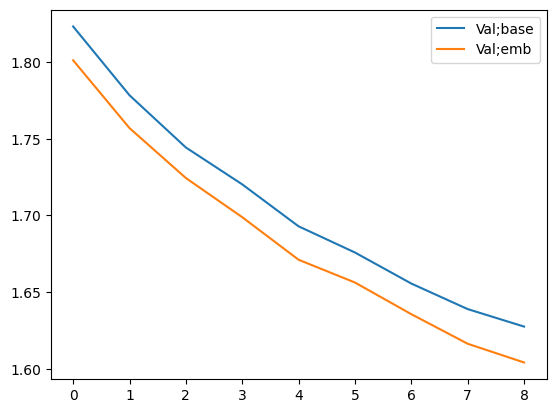

In [13]:
for run in runs:
    plt.plot(run[1][4:], label='Val;' + run[2])
plt.legend()

# Sample

In [18]:
"""
Sample from a trained model
"""
import os
import pickle
from contextlib import nullcontext
import torch

model, _ = load_model('out-emb', model_confs[1], ptdtype, device, device_type)
num_samples = 1
max_new_tokens = 200
top_k = 10
temperature=0.8

start = "a kolem mne i pode mn"

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')

number of parameters: 42.60M
a kolem mne i pode mnou,
kde plachou v pláči pár a země,
kde přijde tělo v podobě mé,
a nezmužil jsem v pracované mé
a já jej pro již duch svůj plížím,
a když se duše dojemně smutně svítí,
a pomocně přelétnul na svátek v 
---------------


## Visualize attention

In [19]:
# Split text into words/non-alfnum.
def split_text(text):
    split, inds, s = [], [], 0
    for i in range(len(text)):
        if not text[i].isalnum():
            if i-s>0:
                split.append(text[s:i])
                inds.append((s, i))
            split.append(text[i])
            inds.append((i, i+1))
            s = i+1
    # Add last word if it's not been added already.
    if i-s>0:
        split.append(text[s:])
        inds.append((s,len(text)))
    assert len(inds) == len(split)
    return split, inds

def merge_att(A, inds):
    l = np.array([A[:, inds[i][0]:inds[i][1]].sum(dim=1).numpy() for i in range(len(inds))])
    f = np.array([l[:, inds[i][0]:inds[i][1]].sum(axis=1) for i in range(len(inds))])
    return f

In [20]:
head = '0'
layer = '0'
batch = 0
iter = 1
split = 'Character'
rang = gptconf.block_size
outs = widgets.Output()
att = runs[1][3]

l = widgets.Dropdown(
    options=[str(i) for i in range(gptconf.n_layer)],
    value=layer,
    description='Layer:',
)
b = widgets.IntSlider(
    value=batch,
    max=batch_size,
    description='Batch:',
)
h = widgets.Dropdown(
    options=[str(i) for i in range(gptconf.n_head)],
    value=head,
    description='Head:',
)
it = widgets.IntSlider(
    value=iter,
    max=len(att[0]) -1,
    description='Iter:',)
r = widgets.IntSlider(
    value=rang,
    max=rang,
    description='Range (block size):',)
s = widgets.ToggleButtons(
    value=split,
    options=['Character', 'Word'],
    button_style='',
)

def showAttention():
    with outs:
        clear_output()
        text = decode(att[1][iter][int(batch)].cpu().numpy())
        print(text)
        plt.figure(figsize=(12,12))
        A = att[0][iter][int(layer)][int(batch)][int(head)]
        if split == "Character":
            A = A[:rang, :rang]
        if split == "Word":
            text, inds = split_text(text)
            A = merge_att(A, inds)
        plt.xticks(range(len(text)), text)
        plt.yticks(range(len(text)), text)
        plt.imshow(A, cmap='hot', interpolation='nearest')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.show()
def on_change_batch(v):
    global batch
    batch = v.new
    showAttention()
def on_change_head(v):
    global head
    head = v.new
    showAttention()
def on_change_layer(v):
    global layer
    layer = v.new
    showAttention()
def on_change_iter(v):
    global iter
    iter = v.new
    showAttention()
def on_change_split(v):
    global split
    split = v.new
    showAttention()
def on_change_range(v):
    global rang
    rang = v.new
    showAttention()
b.observe(on_change_batch, names='value')
h.observe(on_change_head, names='value')
l.observe(on_change_layer, names='value')
it.observe(on_change_iter, names='value')
s.observe(on_change_split, names='value')
r.observe(on_change_range, names='value')
display(l,h,s,b,it,r)
display(outs)

Dropdown(description='Layer:', options=('0', '1', '2', '3', '4', '5'), value='0')

Dropdown(description='Head:', options=('0', '1', '2', '3', '4', '5'), value='0')

ToggleButtons(options=('Character', 'Word'), value='Character')

IntSlider(value=0, description='Batch:', max=128)

IntSlider(value=1, description='Iter:', max=12)

IntSlider(value=128, description='Range (block size):', max=128)

Output()